<a href="https://colab.research.google.com/github/smbsues/Capstone/blob/main/Capstone_Part_3_(Cosine_Sims).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 

In [ ]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import linear_model
drive.mount('/content/drive')

eval_df = pd.read_csv('/content/drive/MyDrive/Capstone/evals_w_rouge.tsv', sep="\t")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
eval_df.columns

Index(['Unnamed: 0', 'de_gold', 'en', 'de_trans', 'sent_gold', 'sent_en',
       'sent_trans', 'Exact_String', 'De_Sentiment_Match',
       'DeG_En_Sentiment_Match', 'DeT_En_Sentiment_Match', 'Precision',
       'Recall', 'fmeasure'],
      dtype='object')

In [ ]:
# load in gottbert

# https://huggingface.co/roberta-base
# https://huggingface.co/uklfr/gottbert-base

from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("uklfr/gottbert-base")

model = AutoModelForMaskedLM.from_pretrained("uklfr/gottbert-base")

In [ ]:
import torch

inputs = tokenizer("Ich liebe <mask>.", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

In [ ]:
outputs.hidden_states

In [ ]:
len(outputs.hidden_states)

13

In [ ]:
s1_embeds_layer9 = outputs.hidden_states[8]

In [ ]:
LAYER_IX = 8

from torch import cosine_similarity

inputs2 = tokenizer("Ich liebe <mask> nicht.", return_tensors="pt")

with torch.no_grad():
    outputs2 = model(**inputs2, output_hidden_states=True)

s2_embeds_layer9 = outputs2.hidden_states[LAYER_IX]

In [ ]:
s1_layer9 = s1_embeds_layer9.mean(axis=1)
s2_layer9 = s2_embeds_layer9.mean(axis=1)

cosine_similarity(s1_layer9, s2_layer9).item()

0.9740766286849976

In [ ]:
sims = []

for index, row in eval_df.iterrows():
  gold = row["de_gold"]
  trans = row["de_trans"]
  inputs_gold = tokenizer(gold, return_tensors="pt")
  inputs_trans = tokenizer(trans, return_tensors="pt")
  with torch.no_grad():
    outputs_gold = model(**inputs_gold, output_hidden_states=True)
    outputs_trans = model(**inputs_trans, output_hidden_states=True)
  embeds_gold_layer_9 = outputs_gold.hidden_states[LAYER_IX]
  embeds_trans_layer_9 = outputs_trans.hidden_states[LAYER_IX]
  gold_embeds_layer_9_mean_pooling = embeds_gold_layer_9.mean(axis=1)
  trans_embeds_layer_9_mean_pooling = embeds_trans_layer_9.mean(axis=1)
  sims.append(cosine_similarity(gold_embeds_layer_9_mean_pooling, trans_embeds_layer_9_mean_pooling).item())

sims

In [ ]:
with open(r'cosine_sims.txt', 'w') as f:
    for item in sims:
        f.write("%s\n" % item)
    print('Done')

Done


In [ ]:
np.mean(sims)

0.9742451395307269

In [ ]:
eval2_df = pd.read_csv('/content/drive/MyDrive/Capstone/total.tsv', sep="\t")

In [ ]:
columns_name = ['Sims']
sims_df = pd.read_csv('/content/drive/MyDrive/Capstone/cosine_sims.txt', sep='|', names=columns_name)

print(sims_df)

In [ ]:
w_sims = pd.concat([eval2_df, sims_df], axis=1, ignore_index=False)

In [ ]:
# w_sims

In [ ]:
print("\033[1mCosine-SD:\033[0m", w_sims['Sentiment_Delta'].corr(w_sims['Sims']))
print("\033[1mCosine-SM:\033[0m", w_sims['De_Sentiment_Match'].corr(w_sims['Sims']))

In [ ]:
es_false = w_sims.loc[w_sims['Exact_String'] == False]

es_false

In [ ]:
cs_sd = (es_false[['Sentiment_Delta', 'Sims']].groupby(["Sentiment_Delta"]).mean())

cs_sd

,Sims
Sentiment_Delta,
-2.0,0.952174
-1.0,0.942988
0.0,0.957274
1.0,0.942663
2.0,0.935514


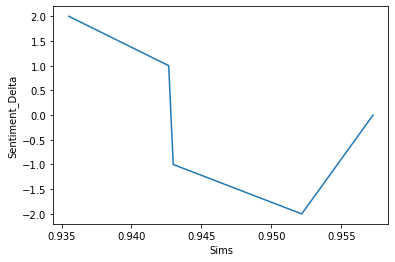

In [ ]:
lp = sns.lineplot(data=cs_sd, x="Sims", y="Sentiment_Delta")
# lp.invert_yaxis()

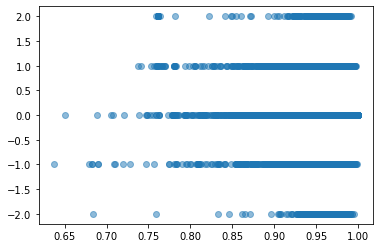

In [ ]:
plt.scatter(x=es_false["Sims"], y=es_false["Sentiment_Delta"], c='#1f77b4', alpha=0.5)

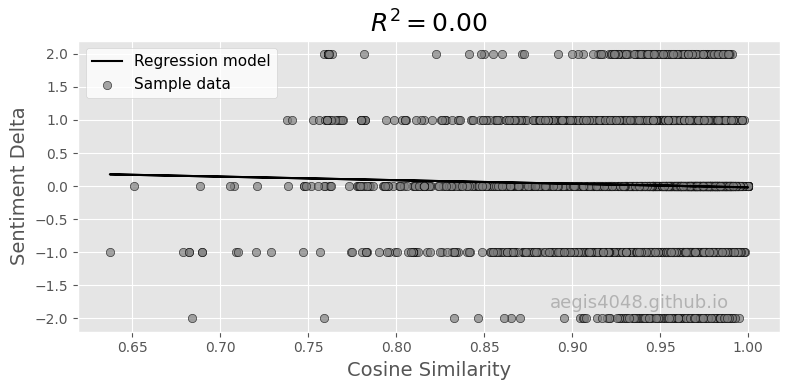

In [ ]:
X = es_false['Sims'].values.reshape(-1,1)
y = es_false['Sentiment_Delta'].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)

regr = linear_model.LinearRegression()
regr.fit(X, y)

r2 = model.score(X, y)

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Sentiment Delta', fontsize=14)
ax.set_xlabel('Cosine Similarity', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()